In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Binary variable of whether a tree has died one year after a fire event.
| YrFireName                  | Fire Name       
| Times_burned                | Times Burned                                             
| Species                     | Species of Tree                                      
| Genus_species               | Genus of Tree Species                                      
| DBH_cm                      | Tree diameter (cm)
| HT_m                        | Tree height (m)
| CR_pre                      | Crown ratio pre-fire
| CR_post                     | Crown ratio post-fire

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

print(trees_dat.shape)

(169843, 64)


/tmp/ipykernel_1405954/529714199.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [3]:
trees_clean = trees_dat.loc[:,['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post']]

trees_clean.dtypes

trees_clean = trees_clean.dropna()

print(f"Number of rows: {trees_clean.shape[0]}")

Number of rows: 36509


In [4]:
for col in ['Genus_species', 'YrFireName', 'Species']:
    trees_clean[col], _ = pd.factorize(trees_clean[col], sort = True)

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [5]:
trees_clean.columns

Index(['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species',
       'DBH_cm', 'HT_m', 'CR_pre', 'CR_post'],
      dtype='object')

In [6]:
trees_clean.head()

,yr1status,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post
500,0.0,37,1,0,0,71.374,41.76,0.84,0.74
501,0.0,37,1,0,0,23.622,12.80,0.60,0.57
502,0.0,37,1,0,0,46.228,34.75,0.75,0.59
503,0.0,37,1,0,0,21.082,23.16,0.38,0.38
504,0.0,37,1,0,0,24.384,26.21,0.42,0.42


In [7]:
X = trees_clean.drop(columns = ['yr1status'])
Y = trees_clean['yr1status']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [8]:
# Verify the training and testing set size
print("Training set observations:", len(X_train))
print("Testing set observations:", len(X_test))

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [9]:
glm = LogisticRegression()

glm.fit(X_train_scaled, y_train)

training_accuracy = glm.score(X_train, y_train)

print(f"Training Accuracy: {training_accuracy:.4f}")

Training Accuracy: 0.9137


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy:  0.9399251346663015
[[9844  189]
 [ 469  451]]


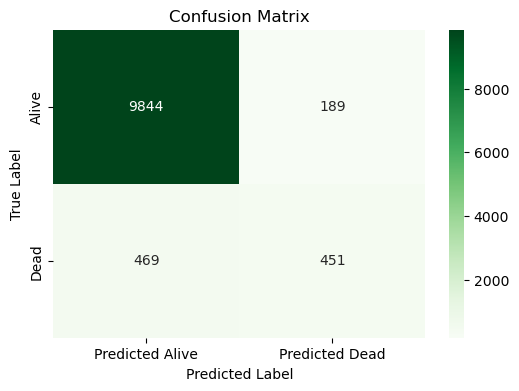

In [10]:
y_train_pred = glm.predict(X_train_scaled)
y_test_pred = glm.predict(X_test_scaled)

training_accuracy = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Accuracy: ", training_accuracy)

#Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt="d", 
            cmap="Greens", 
            xticklabels=["Predicted Alive", "Predicted Dead"], 
            yticklabels=["Alive", "Dead"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

With an accuracy of 93.9%, the model fits well, but only identified about half of the identified dead trees. The dataset contains more survived trees than dead trees, and so favors the prediction of tree survival. This resulted in 469 false negatives, where trees were predicted to survive but actually died. 

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (ALIVE trees)? How would its accuracy compare to your logistic regression model?

The accuracy would be similar because of the high class imablance, with more than 90% alive trees.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 0.9172405697292221
Dummy Confusion Matrix: 
[[23441     0]
 [ 2115     0]]


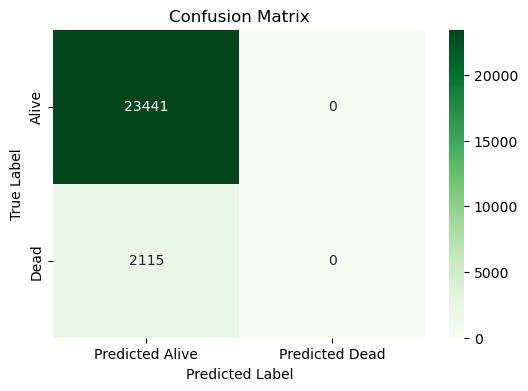

In [11]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train_scaled, y_train)

y_train_dummy_pred = dummy_clf.predict(X_train_scaled)

dummy_accuracy = accuracy_score(y_train, y_train_dummy_pred)

dumb_conf_matrix = confusion_matrix(y_train, y_train_dummy_pred)

print(f"Dummy Accuracy: {dummy_accuracy}")
print(f"Dummy Confusion Matrix: \n{dumb_conf_matrix}")

plt.figure(figsize=(6, 4))
sns.heatmap(dumb_conf_matrix, 
            annot=True, 
            fmt="d", 
            cmap="Greens", 
            xticklabels=["Predicted Alive", "Predicted Dead"], 
            yticklabels=["Alive", "Dead"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [12]:
# Logistic classifier AUC
y_train_prob = glm.predict_proba(X_train_scaled)[:,1]

fpr, tpr, _ = roc_curve(y_train, y_train_prob)

auc = roc_auc_score(y_train, y_train_prob)

print(f"Logistic AUC: {auc}")

Logistic AUC: 0.9299952508904454


In [13]:
# Dummy classifier AUC
y_train_dummy_prob = dummy_clf.predict_proba(X_train_scaled)[:, 1]

fpr_dummy, tpr_dummy, _ = roc_curve(y_train, y_train_dummy_prob)

auc_dummy = roc_auc_score(y_train, y_train_dummy_prob)

print(f"Dummy AUC:", auc_dummy)

Dummy AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

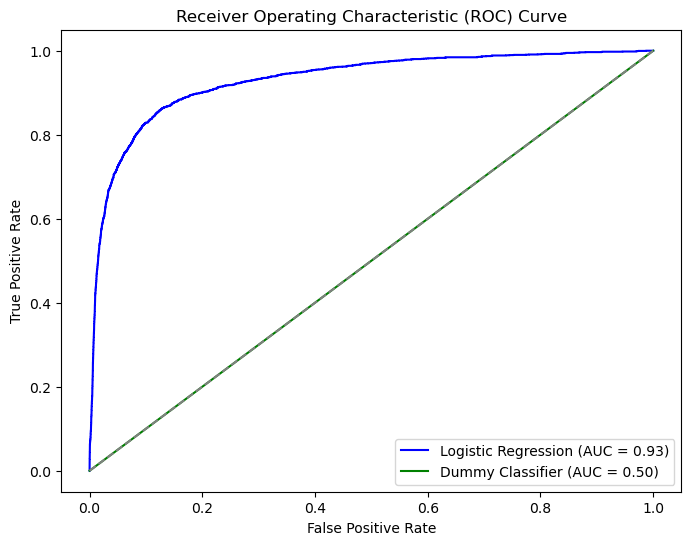

In [14]:
# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Logistic Regression (AUC = %0.2f)' % auc)
plt.plot(fpr_dummy, tpr_dummy, color='green', label='Dummy Classifier (AUC = %0.2f)' % auc_dummy)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The logistic model (AUC = .93) is very good at identifying living and dead trees. The dummy model is just as good at random guessing (AUC = .5). However, both models showed >90% accuracy scores although the logistic model is clearly superior, which is an implication of evaluating the models based on accuracy scores alone. 

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [15]:
feature_names = X_train.columns 
coefficients = glm.coef_[0]

importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

importance_df['Importance'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importance
print(importance_df)

         Feature  Coefficient  Importance
7        CR_post    -2.494974    2.494974
5           HT_m    -1.165414    1.165414
0     YrFireName    -0.660497    0.660497
2        Species     0.541509    0.541509
4         DBH_cm     0.421324    0.421324
6         CR_pre     0.123414    0.123414
3  Genus_species    -0.067867    0.067867
1   Times_burned     0.000000    0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

CR_post (percentage of crown post fire event), HT_m (tree height in meters), and YrFireName (year and fire name) are the most important features in our model. Protecting tall trees and analyzing regional fire history would be useful for forest management. 